In [107]:
from src.preprocessing.dataLoader_CelebA import get_partitioned_dataloaders
from src.ml.own_network import SiameseNetworkOwn
from src.ml.resNet18 import SiameseNetwork
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import torchvision
import yaml
import mlflow

In [108]:
MODEL_PATH = "models/MS_RESNET.pth"

In [109]:
# Load config from YAML
with open("config/config.yml", "r") as f:
    config = yaml.safe_load(f)

# Extract sections
PRE = config["PREPROCESSING"]

# Set constants from preprocessing config
IMAGE_DIR = PRE["image_dir"]
LABEL_FILE = PRE["label_file"]
PARTITION_FILE = PRE["partition_file"]
BATCH_SIZE = PRE["batch_size"] #16
M_PER_SAMPLE = PRE["m_per_sample"]
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [110]:
def plot_all(train_loader):
    # Assuming train_loader uses FilteredCelebADataset with remapped labels

    # Access the underlying dataset from train_loader
    train_dataset = train_loader.dataset

    # Collect one example image per unique label
    unique_labels = sorted(set(train_dataset.labels))
    label_to_img = {}

    for idx, label in enumerate(train_dataset.labels):
        if label not in label_to_img:
            label_to_img[label] = train_dataset[idx][0]  # Assuming dataset[idx] returns (image, label)

    # Plot all unique labels with their example images
    num_labels = len(unique_labels)
    cols = 10
    rows = (num_labels + cols - 1) // cols

    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))
    axes = axes.flatten()

    for i, label in enumerate(unique_labels):
        img = label_to_img[label].permute(1, 2, 0).numpy()

        # Denormalize (if your dataset applies normalization)
        mean = [0.485, 0.456, 0.406]
        std = [0.229, 0.224, 0.225]
        img = img * std + mean
        img = img.clip(0, 1)

        axes[i].imshow(img)
        axes[i].set_title(f"Label: {label}")
        axes[i].axis('off')

    # Hide unused subplots
    for j in range(i+1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()


In [111]:

train_loader, val_loader, test_loader = get_partitioned_dataloaders(
    image_dir=IMAGE_DIR,
    label_file=LABEL_FILE,
    partition_file=PARTITION_FILE,
    m_per_sample=M_PER_SAMPLE,
    batch_size=BATCH_SIZE,
    num_identities=200,
    seed=42
)

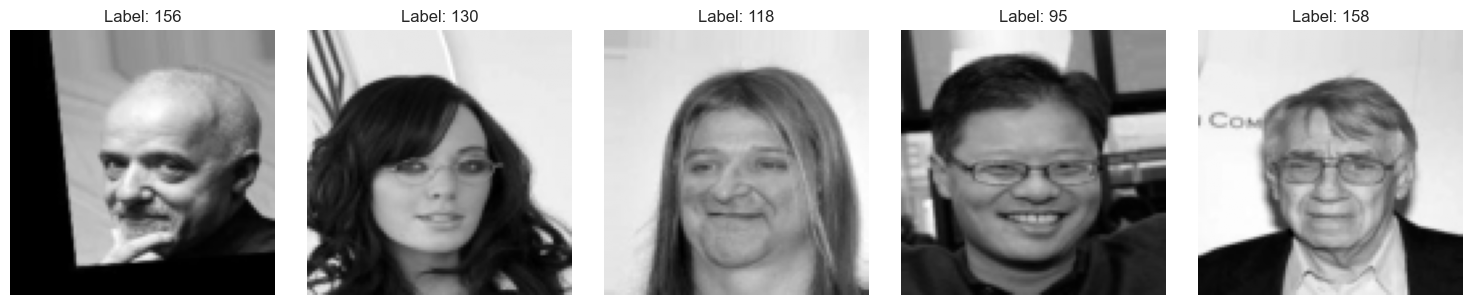

In [112]:
import matplotlib.pyplot as plt
import torch

plt.figure(figsize=(15, 3))

for i in range(5):
    sample = train_loader.dataset[i]
    image, label = sample[0], sample[3]  # image is first, label is fifth

    # Convert image to numpy
    if isinstance(image, torch.Tensor):
        if image.ndim == 3 and image.shape[0] == 1:  # grayscale
            image = image.squeeze().numpy()
            cmap = 'gray'
        elif image.ndim == 3 and image.shape[0] == 3:  # RGB
            image = image.permute(1, 2, 0).numpy()
            cmap = None
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")
    else:
        cmap = 'gray'

    # Convert label to int
    if isinstance(label, torch.Tensor):
        label = label.item()

    plt.subplot(1, 5, i + 1)
    plt.imshow(image, cmap=cmap)
    plt.title(f"Label: {label}")
    plt.axis('off')

plt.tight_layout()
plt.show()


In [113]:
num_batches_val = len(val_loader)
print(f"Number of batches in validation dataloader: {num_batches_val}")
num_samples_train = len(train_loader.dataset)
num_batches_train = len(train_loader)
print(f"Training samples: {num_samples_train}, Batches: {num_batches_train}")

Number of batches in validation dataloader: 10
Training samples: 2803, Batches: 43


In [114]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if "RESNET" in MODEL_PATH:
    net = SiameseNetwork().to(DEVICE)
elif "OWN" in MODEL_PATH:
    net = SiameseNetworkOwn().to(DEVICE)

checkpoint = torch.load(MODEL_PATH, map_location=DEVICE)
net.load_state_dict(checkpoint["model_state_dict"])
net.eval()

SiameseNetwork(
  (cnn1): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [115]:
checkpoint.keys()
#checkpoint["epoch"]

dict_keys(['epoch', 'model_state_dict', 'optimizer_state_dict', 'train_loss', 'val_loss', 'batch_train_loss', 'batch_val_loss'])

✅ Average Intra-Class Cosine Similarity: 0.5285
✅ Average Inter-Class Cosine Similarity: 0.2891


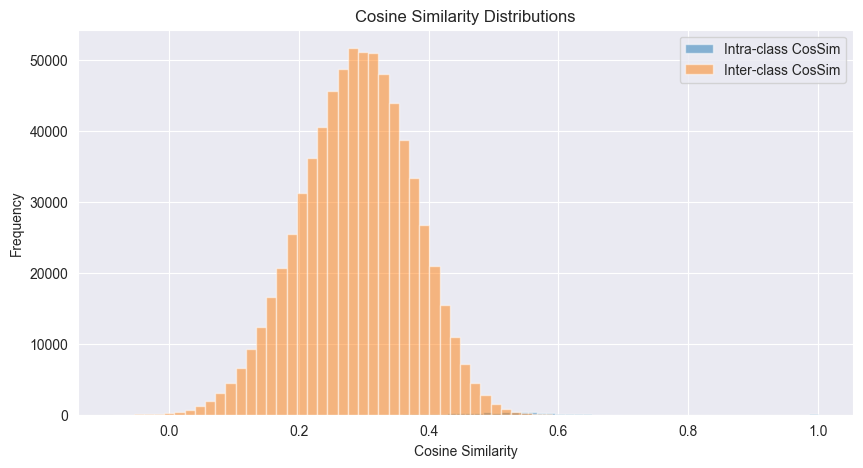

In [116]:
from collections import defaultdict
from itertools import combinations
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Set model to evaluation mode
net.eval()

# Collect embeddings and labels from validation set
all_embeddings = []
all_labels = []

with torch.no_grad():
    for img0, img1, _, label0, label1 in val_loader:
        img0, img1 = img0.to(DEVICE), img1.to(DEVICE)
        label0, label1 = label0.to(DEVICE), label1.to(DEVICE)
        output1, output2 = net(img0, img1)

        all_embeddings.append(torch.cat([output1, output2]))
        all_labels.append(torch.cat([label0, label1]))

# Concatenate all embeddings and labels
all_embeddings = torch.cat(all_embeddings)  # shape: [N, D]
all_labels = torch.cat(all_labels)          # shape: [N]

# Normalize embeddings for cosine similarity
all_embeddings = F.normalize(all_embeddings, p=2, dim=1)

# Group embeddings by class
class_to_embeddings = defaultdict(list)
for emb, label in zip(all_embeddings, all_labels):
    class_to_embeddings[label.item()].append(emb)

for key in class_to_embeddings:
    class_to_embeddings[key] = torch.stack(class_to_embeddings[key])

# Compute intra-class cosine similarities
intra_sims = []
for emb_list in class_to_embeddings.values():
    if len(emb_list) < 2:
        continue
    for i, j in combinations(range(len(emb_list)), 2):
        sim = F.cosine_similarity(emb_list[i].unsqueeze(0), emb_list[j].unsqueeze(0))
        intra_sims.append(sim.item())

# Compute inter-class cosine similarities
inter_sims = []
label_keys = list(class_to_embeddings.keys())
for i in range(len(label_keys)):
    for j in range(i+1, len(label_keys)):
        emb_i = class_to_embeddings[label_keys[i]]
        emb_j = class_to_embeddings[label_keys[j]]
        for e1 in emb_i:
            for e2 in emb_j:
                sim = F.cosine_similarity(e1.unsqueeze(0), e2.unsqueeze(0))
                inter_sims.append(sim.item())

# Compute statistics
avg_intra_sim = sum(intra_sims) / len(intra_sims)
avg_inter_sim = sum(inter_sims) / len(inter_sims)

print(f"✅ Average Intra-Class Cosine Similarity: {avg_intra_sim:.4f}")
print(f"✅ Average Inter-Class Cosine Similarity: {avg_inter_sim:.4f}")

# Optional: Visualize distributions
plt.figure(figsize=(10, 5))
plt.hist(intra_sims, bins=50, alpha=0.5, label='Intra-class CosSim')
plt.hist(inter_sims, bins=50, alpha=0.5, label='Inter-class CosSim')
plt.title("Cosine Similarity Distributions")
plt.xlabel("Cosine Similarity")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.show()


Sample counts per selected label:
Label 180: 8 samples
Label 20: 10 samples
Label 142: 2 samples
Label 176: 8 samples
Label 194: 7 samples
Label 45: 14 samples
Label 177: 7 samples
Label 62: 6 samples
Label 68: 9 samples
Label 166: 7 samples
Label 46: 9 samples
Label 36: 13 samples
Label 192: 11 samples
Label 14: 1 samples
Label 55: 12 samples
Label 76: 15 samples
Label 163: 4 samples
Label 117: 3 samples
Label 15: 7 samples
Label 164: 11 samples
Label 132: 6 samples
Label 35: 3 samples
Label 147: 6 samples
Label 108: 8 samples
Label 16: 4 samples
Label 144: 2 samples
Label 104: 4 samples
Label 139: 3 samples
Label 26: 7 samples
Label 63: 11 samples
Running t-SNE with perplexity=30 on 218 samples...


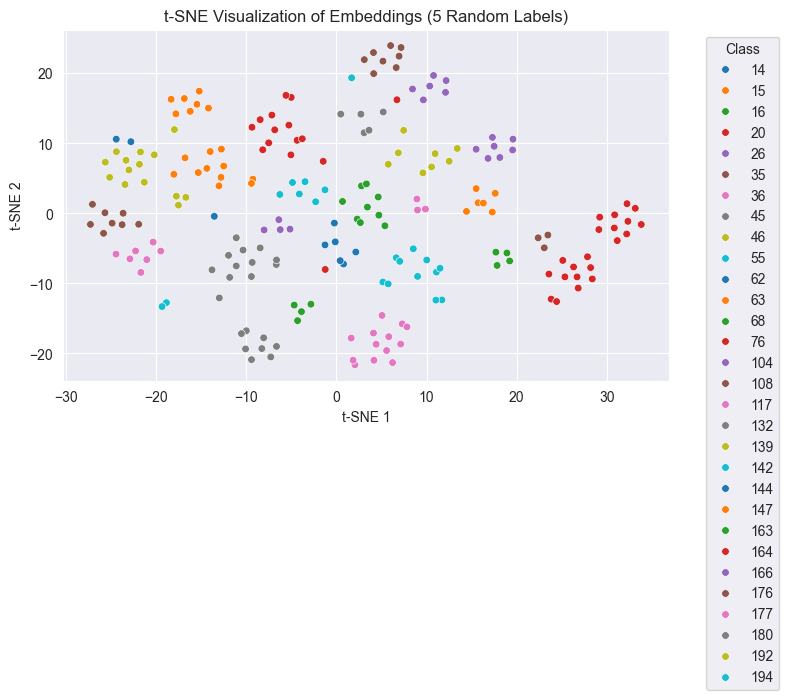

In [117]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns
num = 30
# Convert tensors to NumPy arrays
X = all_embeddings.cpu().numpy()
y = all_labels.cpu().numpy()

# Randomly select 5 unique labels
unique_labels = np.unique(y)
selected_labels = np.random.choice(unique_labels, size=num, replace=False)

# Filter data
mask = np.isin(y, selected_labels)
X_filtered = X[mask]
y_filtered = y[mask]

# Show counts per selected label before running t-SNE
print("Sample counts per selected label:")
for label in selected_labels:
    count = np.sum(y_filtered == label)
    print(f"Label {label}: {count} samples")

# Dynamically adjust perplexity based on sample count
n_samples = X_filtered.shape[0]
perplexity = min(30, (n_samples - 1) // 3)  # perplexity < n_samples / 3

if perplexity < num:
    raise ValueError(f"Too few samples ({n_samples}) for t-SNE to work reliably with 5 labels.")

# --- t-SNE ---
print(f"Running t-SNE with perplexity={perplexity} on {n_samples} samples...")
tsne = TSNE(n_components=2, perplexity=perplexity, max_iter=1000, random_state=42, metric="euclidean")
X_tsne = tsne.fit_transform(X_filtered)

# Plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_filtered, palette='tab10', legend='full', s=30)
plt.title("t-SNE Visualization of Embeddings (5 Random Labels)")
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.grid(True)
plt.show()


In [118]:
# Showing images
def imshow(img, text=None):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})

    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Plotting data
def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.3584211].


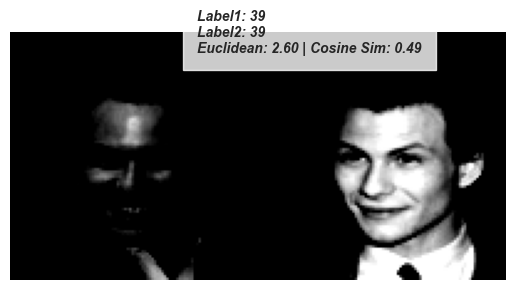

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2489083].


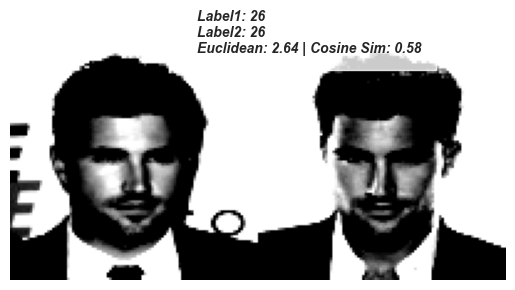

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.923538].


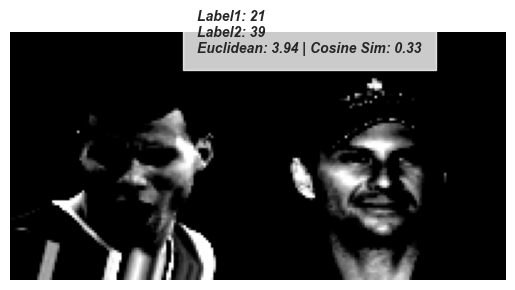

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.11191].


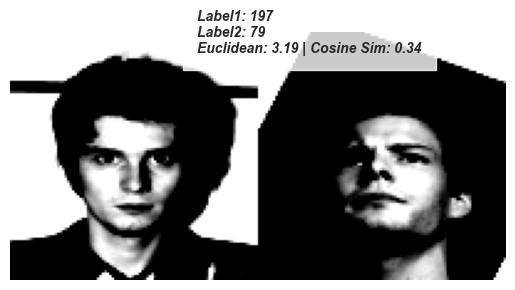

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


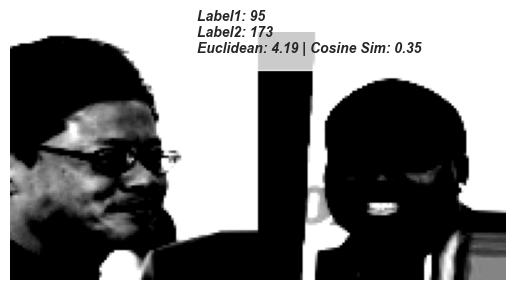

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.980906..2.11191].


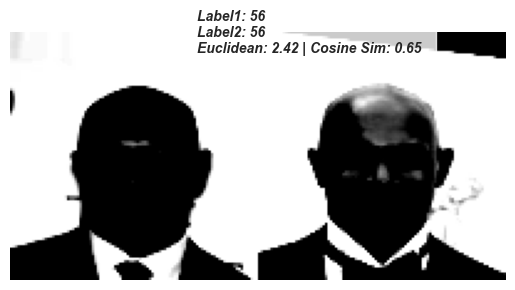

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2317834].


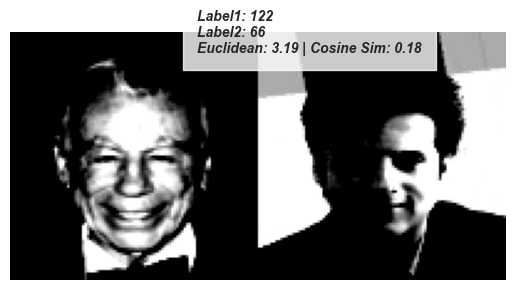

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9295317..2.2489083].


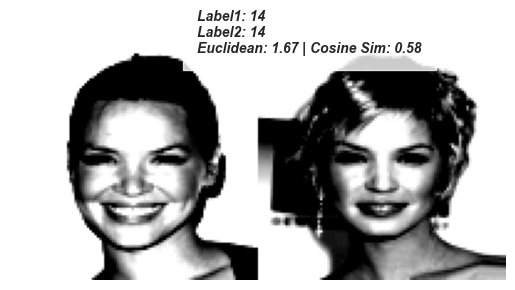

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1632845].


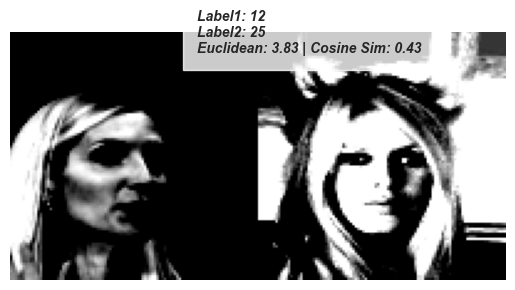

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.0776608].


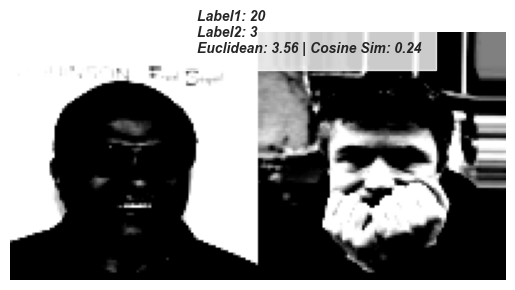

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.843908..2.2317834].


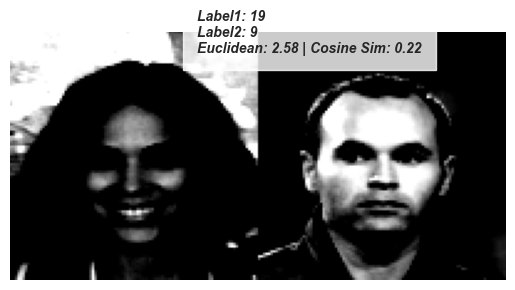

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.0262864].


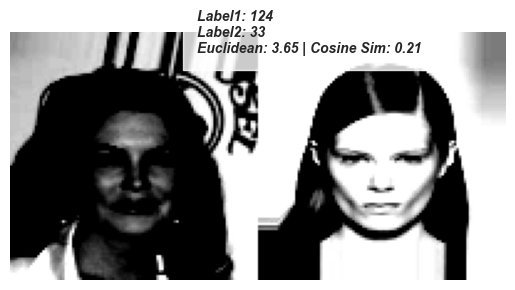

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.11191].


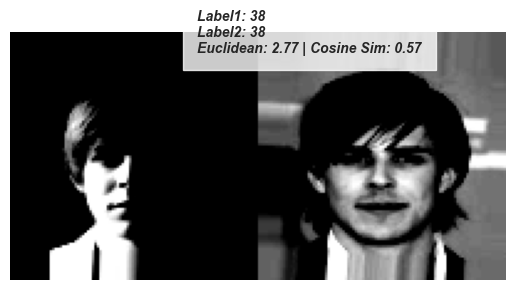

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0151556..2.0947855].


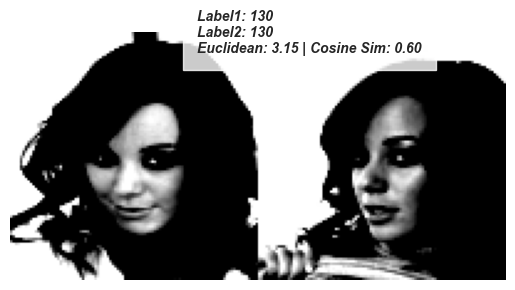

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2146587].


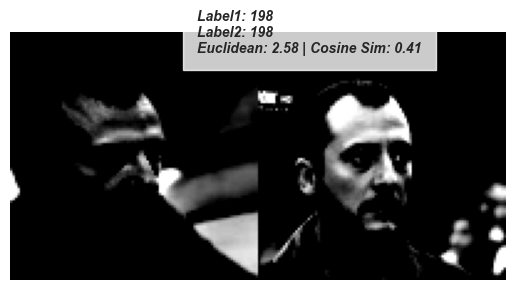

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..1.8721637].


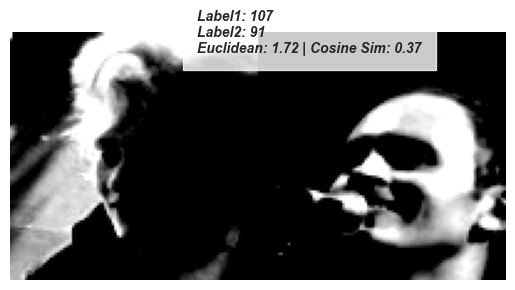

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.11191].


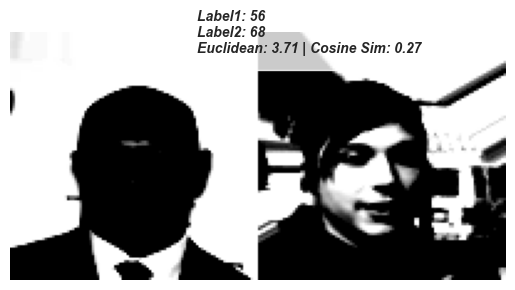

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.923538].


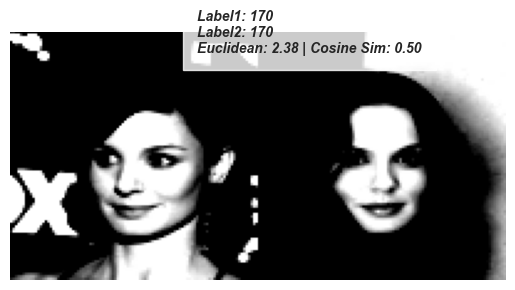

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


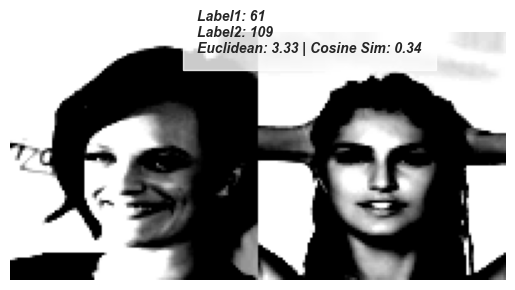

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.8207895].


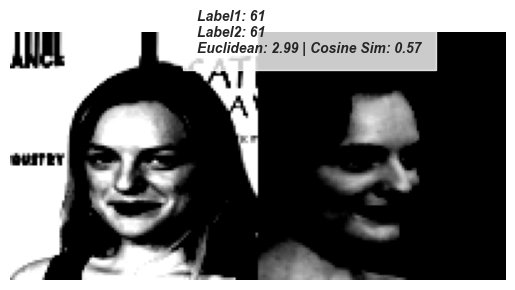

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..1.7351656].


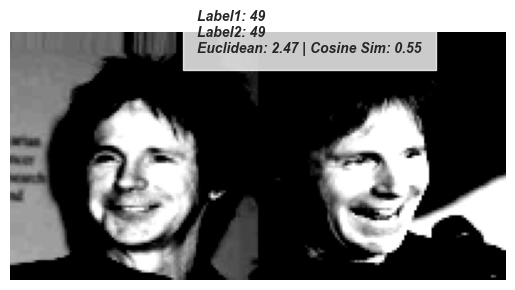

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.129035].


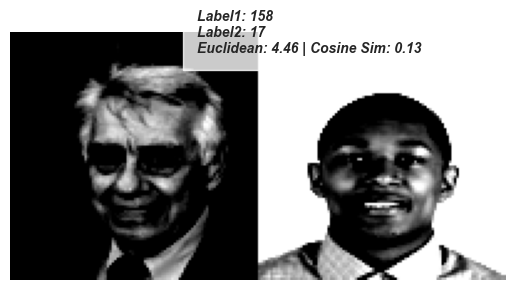

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9980307..1.8036647].


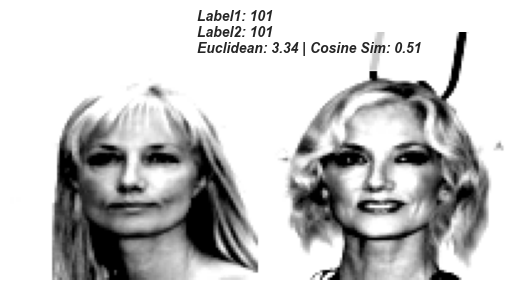

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.7522904].


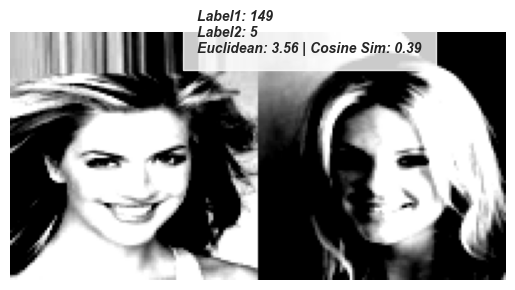

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.2489083].


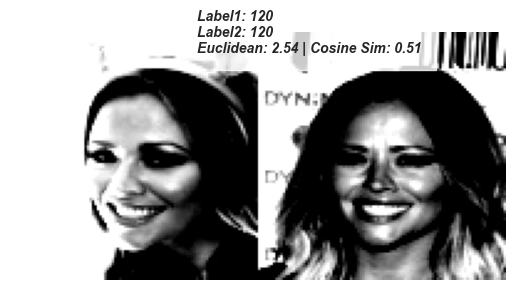

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.11191].


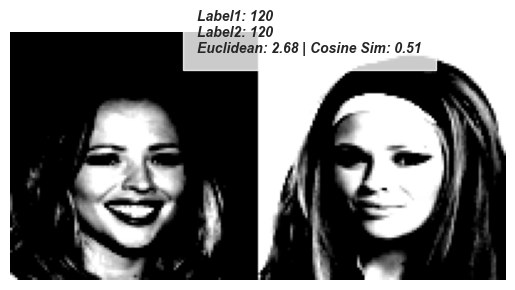

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2146587].


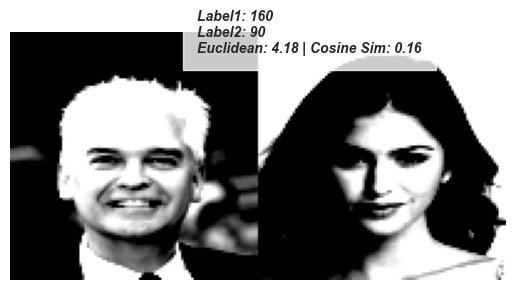

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9749122].


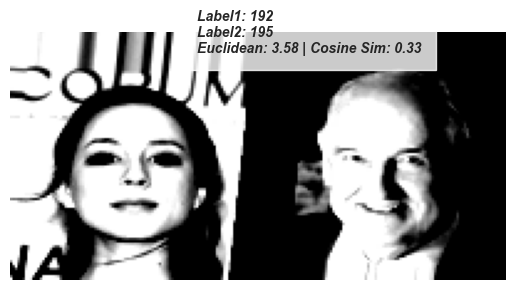

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9406626].


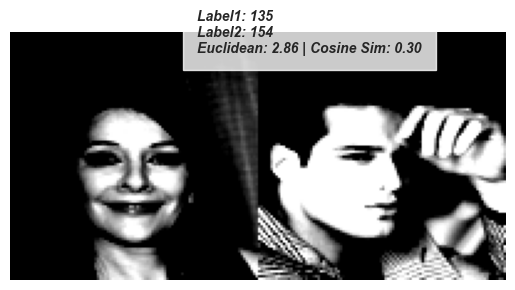

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0665298..2.2146587].


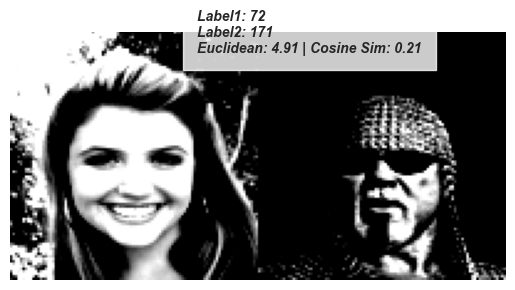

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8096584..2.2489083].


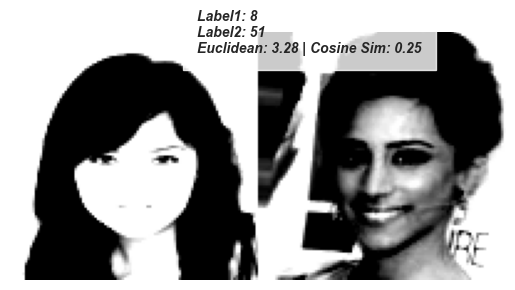

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.1975338].


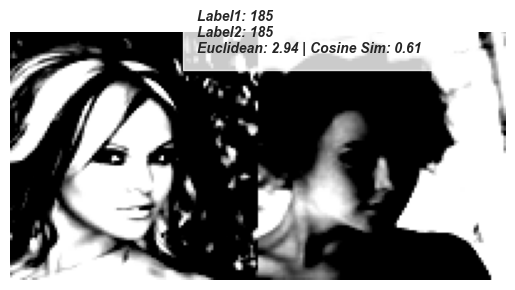

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


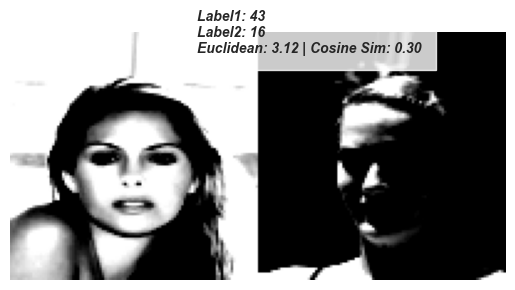

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


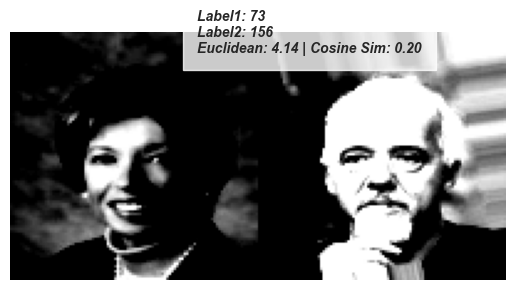

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1975338].


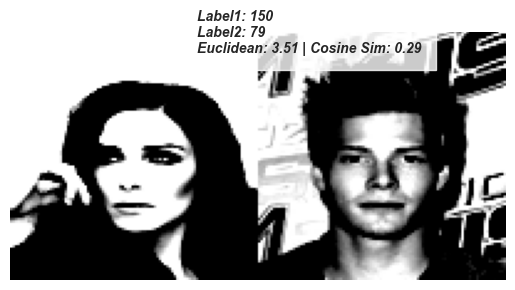

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.1975338].


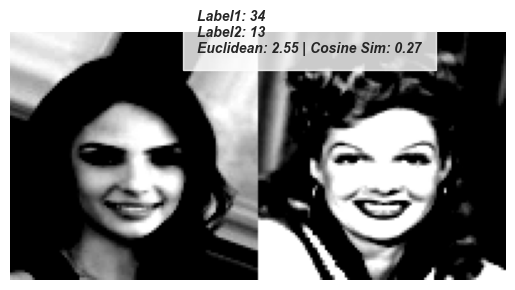

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..1.923538].


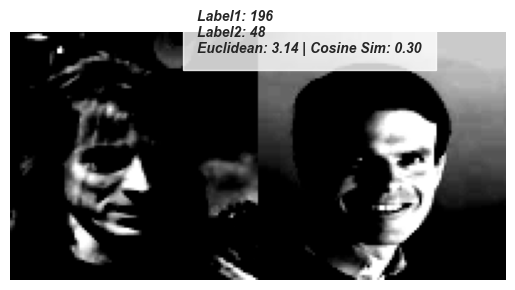

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.9637812..2.2489083].


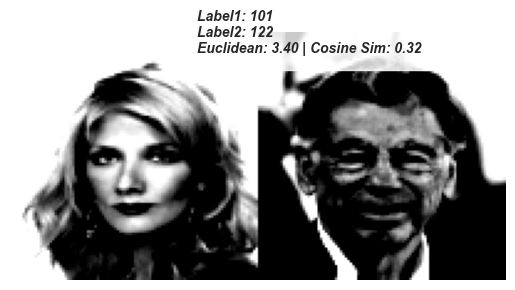

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..2.2489083].


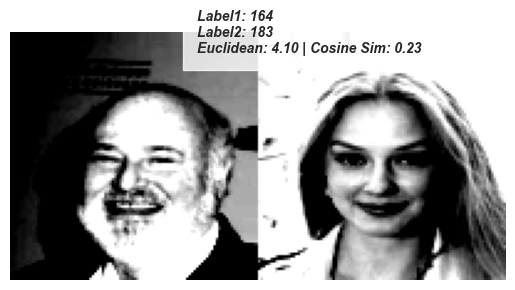

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9406626].


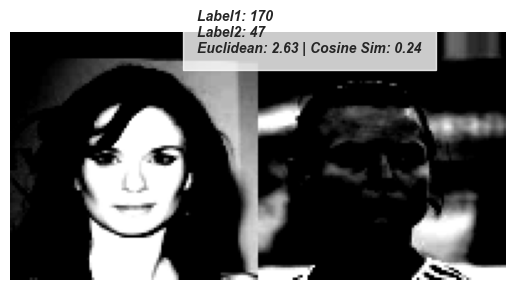

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.1007793..1.9749122].


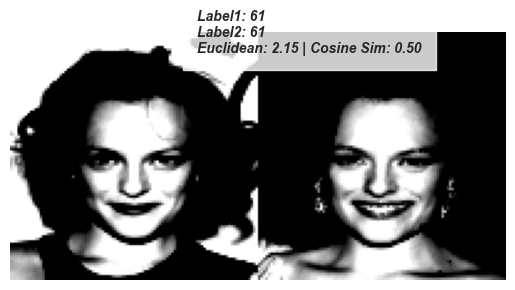

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.2489083].


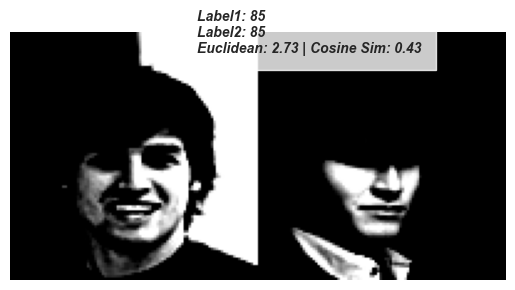

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.1632845].


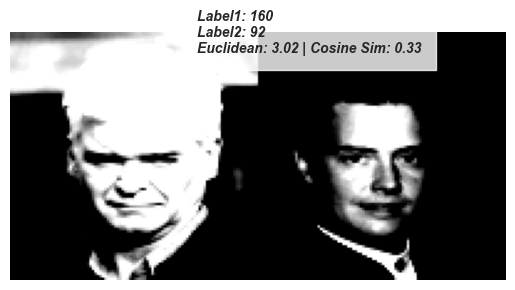

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.8207895].


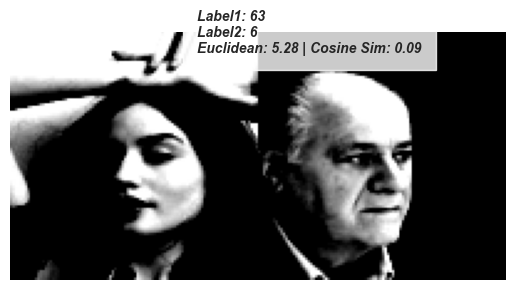

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.2489083].


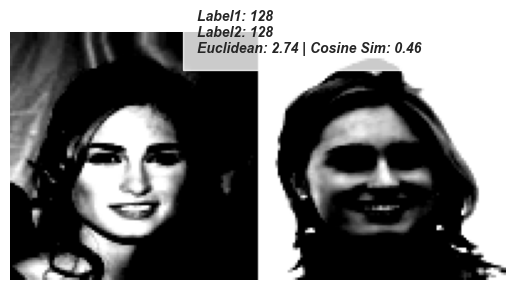

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.1975338].


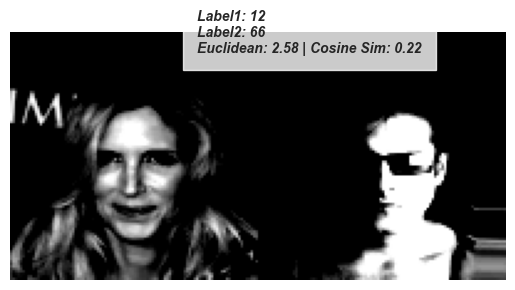

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..1.9577874].


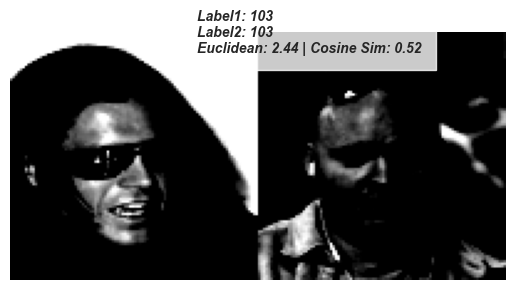

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0322802..2.2489083].


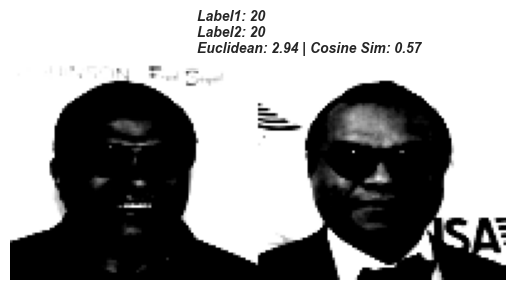

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0494049..2.2489083].


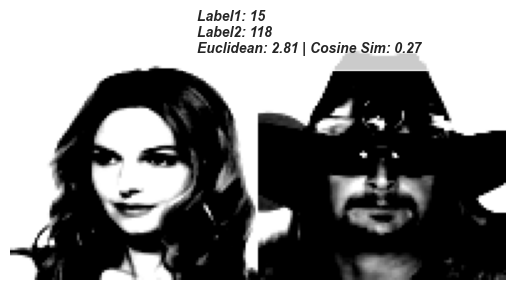

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0836544..2.129035].


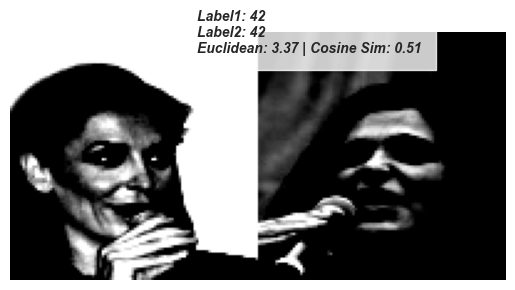

In [119]:
import torch.nn.functional as F
import numpy as np
for i in range(50):
    # Get one sample (batch of 1)
    img1, img2, _, label1, label2 = next(iter(test_loader))

    # Get embeddings
    with torch.no_grad():
        emb1, emb2 = net(img1.to(DEVICE), img2.to(DEVICE))

        # Euclidean Distance
        euclidean_distance = F.pairwise_distance(emb1, emb2)
        cosine_sim = F.cosine_similarity(emb1, emb2)

    # Concatenate images side-by-side
    concatenated = torch.cat((img1[0], img2[0]), 2)

    # Convert labels to list for display
    if isinstance(label1, torch.Tensor):
        lbl1 = label1[0].cpu().numpy().tolist() if label1.dim() > 0 else label1.item()
    else:
        lbl1 = label1

    if isinstance(label2, torch.Tensor):
        lbl2 = label2[0].cpu().numpy().tolist() if label2.dim() > 0 else label2.item()
    else:
        lbl2 = label2

    title = (
        f'Label1: {lbl1}\nLabel2: {lbl2}\n'
        f'Euclidean: {euclidean_distance.item():.2f} | '
        f'Cosine Sim: {cosine_sim.item():.2f}'
    )

    imshow(torchvision.utils.make_grid(concatenated), title)
